In [66]:
from cosmikyu import gan, config, datasets, transforms, stats, mpi, utils
from cosmikyu import nn as cnn
import numpy as np
import os
import torchvision.transforms as pytransforms
import matplotlib.pyplot as plt
import torch as tf
import mlflow
from orphics import maps
from pixell import enplot, enmap

%matplotlib inline
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [67]:
data_dir = config.default_data_dir
sehgal_dir = os.path.join(data_dir, 'sehgal')
cuda = False
compt_idxes = [0,1,2,3,4]
compts = ["kappa", "ksz", "tsz", "ir_pts", "rad_pts"]
shape = (len(compt_idxes),128,128)
latent_dim = 256
sample_interval = 200
batch_size = 1
nepochs=50

_, wcs = maps.rect_geometry(width_arcmin=64*5., height_arcmin=64, px_res_arcmin=0.5)

# Configure data loader
os.makedirs(data_dir, exist_ok=True)
os.makedirs(sehgal_dir, exist_ok=True)

norm_info_file = "/home/dwhan89/workspace/cosmikyu/data/sehgal/201020_logzshrink_normalization_info_validation.npz"
SDN = transforms.SehgalDataNormalizerScaledLogZShrink(norm_info_file)
SUN = transforms.SehgalDataUnnormalizerScaledLogZShrink(norm_info_file)
RF = transforms.RandomFlips(p_v=0.5, p_h=0.5)

SDS_test = datasets.SehgalDataSet(sehgal_dir, "test141020", transforms=[SDN], dummy_label=False)
plot_dir = "/home/dwhan89/scratch/outbox/cosmikyu"
def plot_path(x):
    return os.path.join(plot_dir, x)

In [68]:
STanh = cnn.ScaledTanh(30., 2./30.)
LF = cnn.LinearFeature(5,5)
MCM = transforms.MultiComptMultiply([1, 1, 1, 1, 1])
FORSE = gan.FORSE_WGP("sehgal_forse_081020", shape, nconv_fcgen=64,
                          nconv_fcdis=64, cuda=cuda, ngpu=4, nconv_layer_gen=5, nconv_layer_disc=5, kernal_size=4, stride=2,
                          padding=1, output_padding=0, gen_act=[LF,STanh], nin_channel=5, nout_channel=5, nthresh_layer_gen=0, nthresh_layer_disc=0, dropout_rate=0)


SDS_input = datasets.SehgalDataSet(sehgal_dir, "train_tertiary081120", transforms=[SDN], dummy_label=False, dtype=np.float32)

experiment_id = "e5202767a9d34789a84d043abafc061e"
model_dir = "/home/dwhan89/workspace/cosmikyu/output/sehgal_forse_081020/{}/model".format(experiment_id)
nsample = 100
nbins = 10000
data = np.zeros((5, 128, 128*nsample))
#DCGAN_WGP.load_states(model_dir)
print(model_dir)
save_points = [0,1,2,3,4,5,6]#np.arange(0,4,1)
generated = {}
for save_point in save_points:
    print("processing save points {}".format(save_point))
    FORSE.load_states(model_dir, "_{}".format(save_point))
    
    for i in range(nsample):
        if i % 1000 == 0: print(i)
        sidx = 128*i
        data[...,sidx: sidx+128] = FORSE.generate_samples(SDS_input[i], concat=False, train=False).data.numpy()[0]
    data = MCM(data)
    print(np.max(data))
    MB = stats.FastMultBinner((-30,30), nbins, shape[0])
    MB.bin(data)

    temp = MB.get_info()
    
    for key in range(5):
        generated[SDN.channel_idxes[key]+"_{}".format(save_point)] = temp[key].copy()
print("Done")
np.savez("/home/dwhan89/workspace/cosmikyu/data/sehgal/261020_normalized_histogram_generated_forse_{}.npz".format(nbins), **generated)

/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Traceback (most recent call last):
  File "/home/dwhan89/.miniconda3/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 197, in list_experiments
    experiment = self._get_experiment(exp_id, view_type)
  File "/home/dwhan89/.miniconda3/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 260, in _get_experiment
    meta = read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "/home/dwhan89/.miniconda3/lib/python3.7/site-packages/mlflow/utils/file_utils.py", line 167, in read_yaml
    raise MissingConfigException("Yaml file '%s' does not exist." % file_path)
mlflow.exceptions.M

[WARNING] You have a CUDA device. You probably want to run with CUDA enabled
/home/dwhan89/workspace/cosmikyu/output/sehgal_forse_081020/e5202767a9d34789a84d043abafc061e/model
processing save points 0
loading saved states _0
0
28.355083465576172
processing save points 1
loading saved states _1
0
29.139833450317383
processing save points 2
loading saved states _2
0
29.078516006469727
processing save points 3
loading saved states _3
0
28.778366088867188
processing save points 4
loading saved states _4
0
28.891613006591797
processing save points 5
loading saved states _5
0
28.482563018798828
processing save points 6
loading saved states _6
0
29.935068130493164
Done


In [73]:

for save_point in save_points:
    FORSE.load_states(model_dir, "_{}".format(save_point))
    print(FORSE.generator.model_dict["LF"].weight)
    print(FORSE.generator.model_dict["LF"].bias)

/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


loading saved states _0
Parameter containing:
tensor([0.9989, 1.0083, 0.9637, 1.0135, 1.0069], requires_grad=True)
Parameter containing:
tensor([-0.0102,  0.0193,  0.0262, -0.0088,  0.0166], requires_grad=True)
loading saved states _1
Parameter containing:
tensor([0.9810, 0.9987, 0.9373, 1.0086, 1.0567], requires_grad=True)
Parameter containing:
tensor([-0.0110,  0.0188,  0.0317, -0.0080,  0.0010], requires_grad=True)
loading saved states _2
Parameter containing:
tensor([1.0317, 0.9998, 0.9574, 1.0241, 1.0858], requires_grad=True)
Parameter containing:
tensor([-0.0120,  0.0191,  0.0332, -0.0093, -0.0066], requires_grad=True)
loading saved states _3
Parameter containing:
tensor([1.0924, 1.0008, 0.9657, 1.0473, 1.1062], requires_grad=True)
Parameter containing:
tensor([-0.0124,  0.0201,  0.0340, -0.0091, -0.0115], requires_grad=True)
loading saved states _4
Parameter containing:
tensor([1.1271, 1.0135, 0.9691, 1.0519, 1.1266], requires_grad=True)
Parameter containing:
tensor([-0.0118,  0

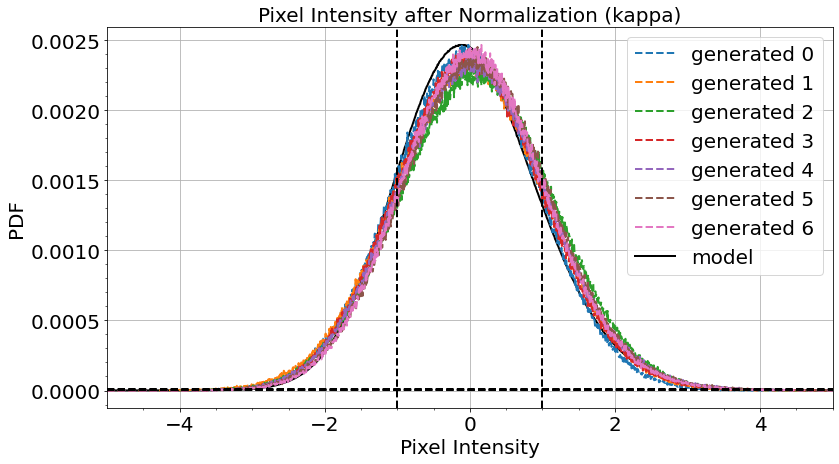

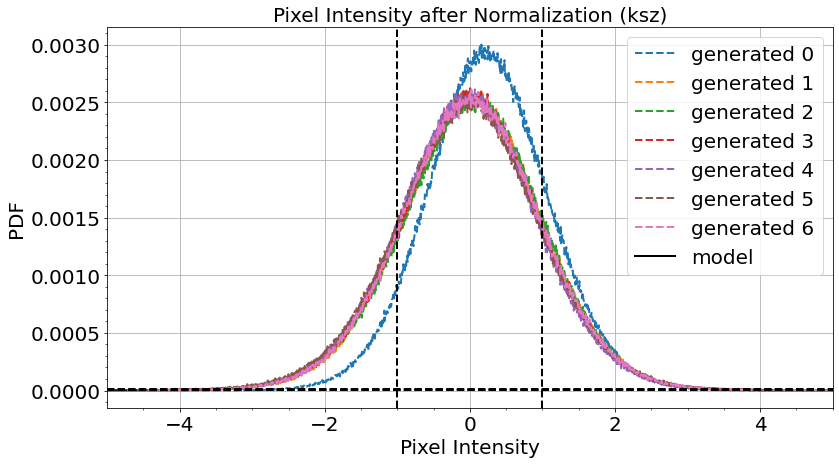

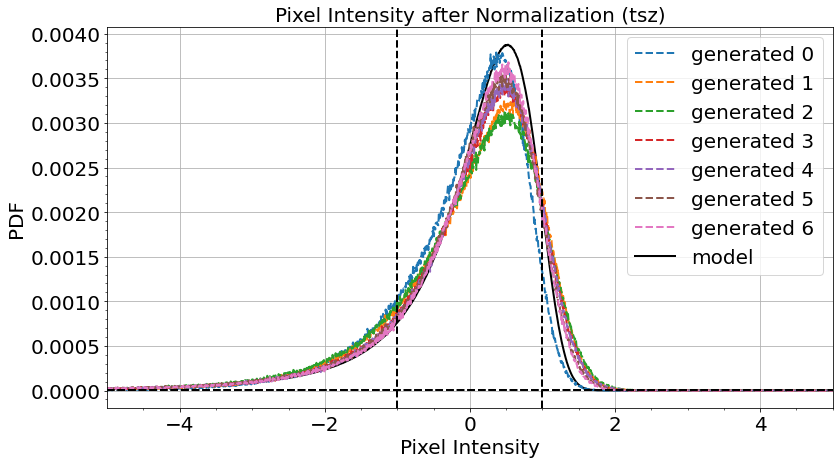

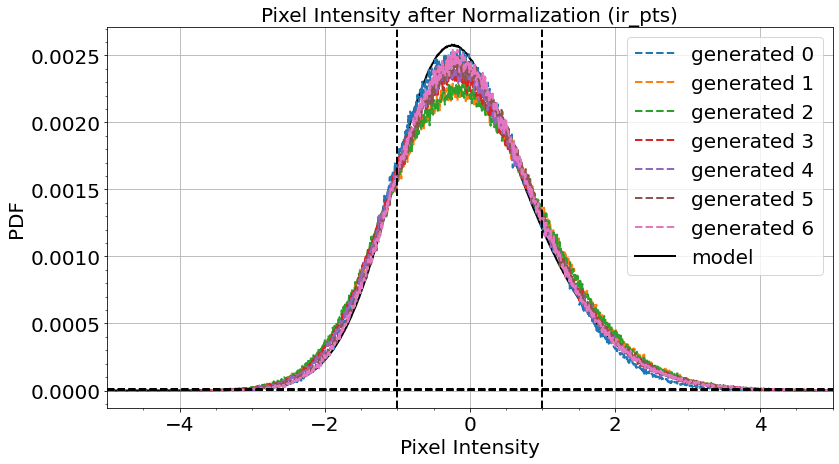

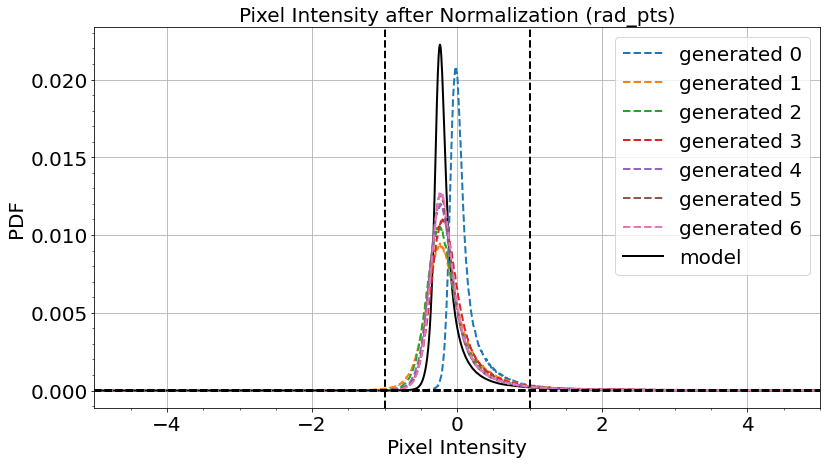

In [74]:
model =  utils.load_data(
    "/home/dwhan89/workspace/cosmikyu/data/sehgal/201020_normalized_histogram_test_{}.npz".format(nbins))
generated = utils.load_data(
    "/home/dwhan89/workspace/cosmikyu/data/sehgal/261020_normalized_histogram_generated_forse_{}.npz".format(nbins))

compts = ["kappa", "ksz", "tsz", "ir_pts", "rad_pts"]
for key in compts:
    fig = plt.figure(figsize=(13, 7))
    ax = fig.gca()
    hist_model = model[key]['hist']
    bins_model = model[key]["bin_centers"]
    nsum_model = np.sum(hist_model)
    pdf_model = hist_model/nsum_model
    plt.plot(bins_model, pdf_model, alpha=1, ls="-", lw=2, color="k")
    
    for save_point in save_points[:]:
        gen_key = "{}_{}".format(key, save_point)
        hist_generated = generated[gen_key]['hist']
        bins_generated = generated[gen_key]["bin_centers"]
        nsum_generated = np.sum(hist_generated)
        pdf_hist = hist_generated/nsum_generated   
        plt.plot(bins_generated, pdf_hist, alpha=1, lw=2, ls="--", label="generated {}".format(save_point))
    
    plt.plot([], [], label="model", ls="-", lw=2, color="k")
    #plt.plot([], [], label="generated", ls="-", lw=2, color="b")

    plt.title("Pixel Intensity after Normalization (%s)"%key, fontsize=20)
    plt.xlabel("Pixel Intensity", fontsize=20)
    plt.ylabel("PDF", fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.tick_params(axis='both', which='minor', labelsize=20)
    plt.legend(fontsize=20)
    plt.axvline(x=1, ls="--", lw=2, color="k")
    plt.axvline(x=-1, ls="--", lw=2, color="k")
    plt.axhline(y=1e-5, ls="--", lw=2, color="k")
    plt.axhline(y=1e-6, ls="--", lw=2, color="k")
    plt.axhline(y=1e-7, ls="--", lw=2, color="k")
    plt.xlim(-5,5)
    #plt.yscale("log")
    plt.minorticks_on()
    ax.tick_params(axis='x', which='minor', bottom=True)
    plt.grid()
    plt.show()
    


/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide

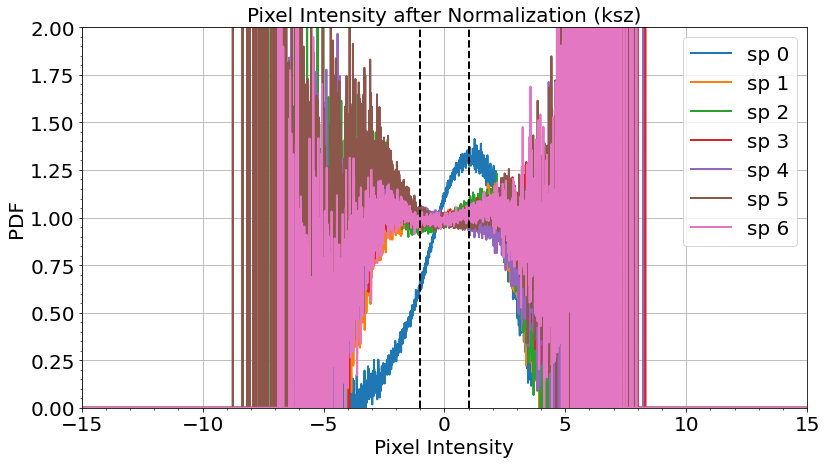

/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/home/d

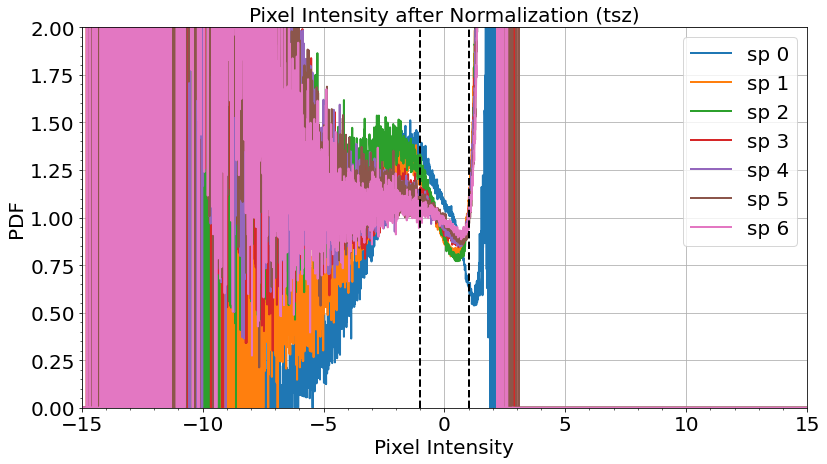

/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/home/dwh

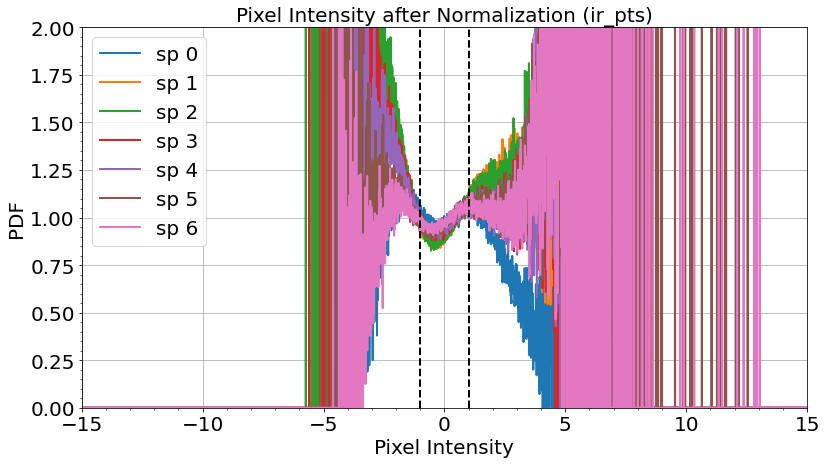

/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/home/d

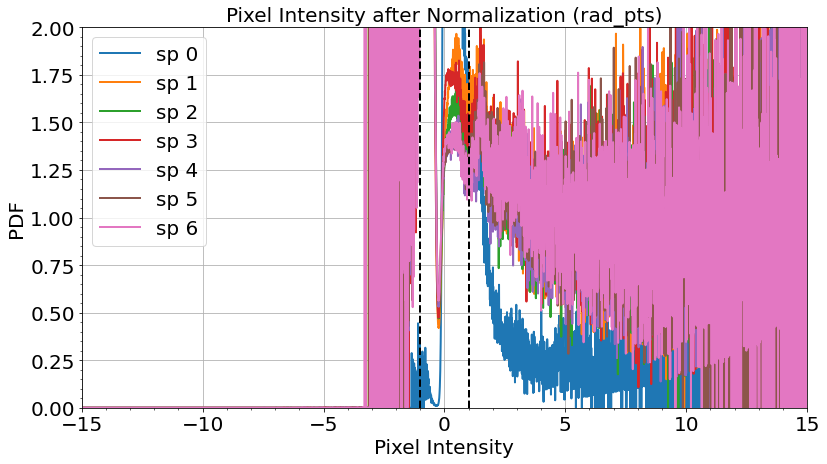

In [75]:
compts = ["ksz", "tsz", "ir_pts", "rad_pts"]
for key in compts:
    fig = plt.figure(figsize=(13, 7))
    ax = fig.gca()
    hist_model = model[key]['hist']
    bins_model = model[key]["bin_centers"]
    nsum_model = np.sum(hist_model)
    pdf_model = hist_model/nsum_model
    
    for save_point in save_points:
        gen_key = "{}_{}".format(key, save_point)
        hist_generated = generated[gen_key]['hist']
        bins_generated = generated[gen_key]["bin_centers"]
        nsum_generated = np.sum(hist_generated)
        pdf_hist = hist_generated/nsum_generated   
        plt.plot(bins_generated, np.nan_to_num(pdf_hist/pdf_model), alpha=1, lw=2, ls="-", label="sp {}".format(save_point))


    plt.title("Pixel Intensity after Normalization (%s)"%key, fontsize=20)
    plt.xlabel("Pixel Intensity", fontsize=20)
    plt.ylabel("PDF", fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.tick_params(axis='both', which='minor', labelsize=20)
    plt.legend(fontsize=20)
    plt.axvline(x=1, ls="--", lw=2, color="k")
    plt.axvline(x=-1, ls="--", lw=2, color="k")
    plt.xlim(-15,15)
    plt.ylim(0,2)
    plt.minorticks_on()
    ax.tick_params(axis='x', which='minor', bottom=True)
    plt.grid()
    plt.show()

In [14]:
def make_hstrip(array):
    shape = array.shape
    if shape[0] < 2: return array
    else:
        nc, ny, nx = shape
        nnx = nx*nc
        ret = np.zeros((ny, nnx))
        for i in range(nc):
            sx = i*nx
            ret[:,sx:sx+nx] = array[i,...].copy()
        return ret
SDN = transforms.SehgalDataNormalizerScaledLogZShrink(norm_info_file)
SDUN = transforms.SehgalDataUnnormalizerScaledLogZShrink(norm_info_file)

SDN_GK = transforms.SehgalDataNormalizerScaledLogZShrink(norm_info_file, channel_idxes=["kappa"])
GK = datasets.SehgalDataSet(sehgal_dir, data_type="Gkappa021120", transforms=[SDN_GK], dummy_label=False, dtype=np.float64, shape=(1,128,128))

print(SDN.channel_idxes[::-1])
print("Original Sehgal sim (64x64) arcmin^2")
enplot.pshow(enmap.enmap(make_hstrip(SDUN(SDS_test[3])), wcs))
print("ML Reproduction (64x64) arcmin^2")
enplot.pshow(enmap.enmap(make_hstrip(SDUN(PIXGAN.generate_samples(GK[3], True).data.numpy()[0])), wcs))

TypeError: __init__() got an unexpected keyword argument 'data_type'

/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


loading saved states _6
0 kappa
1 ksz
2 tsz
3 ir_pts
4 rad_pts


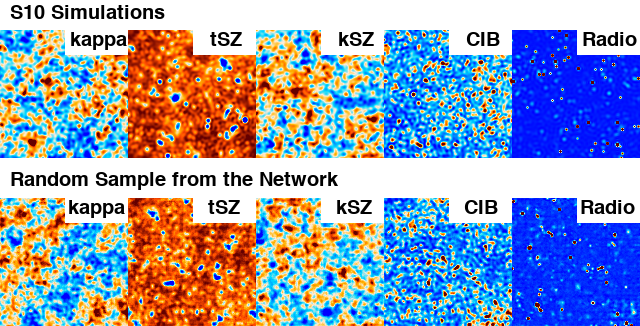

/home/dwhan89/workspace/cosmikyu/cosmikyu/../output/plots/261020_stamp_stacked.png


In [76]:
from PIL import Image
from IPython.display import display
from PIL import ImageFont
from PIL import ImageDraw 

FORSE.load_states(model_dir, "_{}".format(save_points[-1]))
SDS_test = datasets.SehgalDataSet(sehgal_dir, "test141020", transforms=[SDN], dummy_label=False)
#SDS_test = datasets.SehgalDataSet(sehgal_dir, data_type="train_secondary281020", transforms=[SDN],
#                                  dummy_label=False, dtype=np.float32)


plot_dir = os.path.join(config.default_output_dir, "plots")
def plot_path(x):
    return os.path.join(plot_dir, x)

_, wcs = maps.rect_geometry(width_arcmin=64., height_arcmin=64, px_res_arcmin=0.5)
emap_gen = enmap.zeros(shape, wcs)
emap_test = enmap.enmap(SDUN(SDS_test[10]), wcs)
nrpeat = 1
for i in range(nrpeat):
    emap_gen += enmap.enmap(SDUN(FORSE.generate_samples(SDS_input[10], concat=False, train=False).data.numpy()[0]), wcs)
emap_gen /= nrpeat
for i, idx in enumerate(SDN.channel_idxes):
    print(i,idx)
    plot_test = enplot.plot(emap_test[i], grid=False)
    plot_gen = enplot.plot(emap_gen[i], grid=False)
    
    enplot.write(plot_path("{}_test".format(idx)), plot_test)
    enplot.write(plot_path("{}_gen".format(idx)), plot_gen)
    
nimages = len(SDN.channel_idxes)
imgs_test = [None]*nimages
imgs_gen = [None]*nimages

titles = {"kappa": "kappa", "ksz": "  kSZ", "tsz": "  tSZ", "ir_pts": "  CIB", "rad_pts": "Radio"}

swap = [0,2,1,3,4]

for i, idx in enumerate([SDN.channel_idxes[i] for i in swap]):
    fontsize = 20 if idx == "kappa" else 20
    font = ImageFont.truetype("/home/dwhan89/.fonts/Helvetica-Bold.ttf", fontsize)
    imgs_test[i] = Image.open(plot_path("{}_test.png".format(idx)))
    draw = ImageDraw.Draw(imgs_test[i])
    
    draw.rectangle(((65, 0), (130, 24)), fill="white")
    draw.text((70, 0), titles[idx], fill="black",font=font)
    
    imgs_gen[i] = Image.open(plot_path("{}_gen.png".format(idx)))
    draw = ImageDraw.Draw(imgs_gen[i])
    draw.rectangle(((65, 0), (130, 24)), fill="white")
    draw.text((68, 0), titles[idx], fill="black",font=font)
    #display(imgs_gen[i])

def get_concat_h(im1, im2, wspace=0):
    dst = Image.new('RGB', (im1.width+wspace + im2.width, im1.height), color="#FFFFFF")
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width+wspace, 0))
    return dst

def get_concat_v(im1, im2, hspace=40):
    dst = Image.new('RGB', (im1.width, im1.height+hspace+im2.height), color="#FFFFFF")
    dst.paste(im1, (0, 0))
    dst.paste(im2, (0, im1.height+hspace))
    return dst

def pad(im, tpad=30, bpad=0, lpad=0, rpad=0):
    dst = Image.new('RGB', (im.width+lpad+rpad, im.height+tpad+bpad), color="#FFFFFF")
    dst.paste(im, (lpad, tpad))
    return dst

strip_test = imgs_test[0].copy()
strip_gen = imgs_gen[0].copy()
for i in range(1,nimages):
    strip_test = get_concat_h(strip_test, imgs_test[i])
    strip_gen = get_concat_h(strip_gen, imgs_gen[i])
padded = pad(get_concat_v(strip_test, strip_gen))
draw = ImageDraw.Draw(padded)
draw.text((10, 3), "S10 Simulations", fill="black",font=font)
draw.text((10, 170), "Random Sample from the Network", fill="black",font=font)
display(padded)

print(plot_path("261020_stamp_stacked.png"))
padded.save(plot_path("261020_stamp_stacked.png"), "png")